In [1]:
import scipy as sp
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylabㅌ
import pandas as pd
import seaborn as sns
import random
import os
sns.set_style("ticks")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}



session_name="Data/Results_standard/test"
import pickle


# Function Definition

In [2]:
from scipy.integrate import odeint

'''

def gLV(y, t, I_simul, g_simul, k_simul):
    dydt = np.zeros_like(y)
    for i in range(len(y)):
        dydt[i] = g_simul[i]* y[i] * (1- np.sum(I_simul[i,:] * y)/k_simul[i])
    return dydt

def run_lotka_volterra_dynamics(y0, t, s_idx, I, g, k):
    
    s_idx=np.where(s_idx)[0].tolist()
    N=len(y0)
    y0_simul=y0[s_idx]
    I_simul=I[s_idx,:]
    I_simul=I_simul[:,s_idx]
    g_simul=g[s_idx]
    k_simul=k[s_idx]
    
    
    y = odeint(gLV, y0_simul, t, args=(I_simul, g_simul, k_simul))
    y_out=np.zeros(N)
    for i in range(y.shape[1]):
        y_out[s_idx[i]]=y[-1,i] 
    return y
'''
def gLV_env(y, t, beta, delta, migration_rate, I, g, k, p, q, varIdx):
    # p : species -> pH
    # q : pH -> species
    dydt = np.zeros(len(varIdx['env']) + len(varIdx['species']))
    
    growth_rate_multiplier = 1 - (np.matmul(I, y[varIdx['species']])) / k + np.matmul(q, y[varIdx['env']])
    
    dydt[varIdx['species']] = np.multiply(np.multiply(y[varIdx['species']], g), growth_rate_multiplier) + migration_rate #- death_rate * y[varIdx['species']]
    dydt[varIdx['env']] = delta * (-y[varIdx['env']]) + beta* np.matmul(p, y[varIdx['species']]) - delta * 0.0001 * y[varIdx['env']]**5
    
    return dydt

def run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=False):
    

    N=system_config['N']
    N_env=system_config['N_env']
    beta = system_config['beta']
    delta = system_config['delta']
    migration_rate = system_config['migration_rate']
    I = system_config['I']
    g = system_config['g']
    k = system_config['k']
    p = system_config['p']
    q = system_config['q']
                                   
    I=I[species_index,:]
    I=I[:,species_index]
    g=g[species_index]
    k=k[species_index]
    p=p[:,species_index] # p is N_env x N
    p=p[env_index,:]                               
    q=q[species_index,:] # q is N x N_Nev
    q=q[:,env_index]                             
    
    varIdx={'species' : np.arange(len(species_index)),
           'env' : np.arange(len(species_index),len(species_index)+len(env_index))}
    y0=np.concatenate((y0_species, y0_env))
    
    y = odeint(gLV_env, y0, t, args=(beta, delta, migration_rate, I, g, k, p, q, varIdx), atol=1e-12, rtol=1e-10)
    y_out={}
    y_out_species=np.zeros(N)
    y_out_env=np.zeros(N_env)

    for i in range(len(species_index)):
        y_out_species[species_index[i]]=y[-1,i]
        y_out['species']=y_out_species
    for i in range(len(env_index)):
        y_out_env[env_index[i]]=y[-1,len(species_index)+i]
        y_out['env']=y_out_env
    
    if to_plot:
        # Create plots
        fig, axs = plt.subplots(2, 1, figsize=(7, 6))  # 2 Rows, 1 Column

        # Plotting species data
        for i in range(len(species_index)):
            axs[0].plot(t, y[:, i], label=f'Species {i+1}')
        axs[0].set_title('Species Time Series')
        axs[0].set_xlabel('Time (log scale)')
        axs[0].set_ylabel('Value (log scale)')
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].axhline(y=1e-6, color='r', linestyle='dotted', linewidth=1)
        axs[0].set_ylim(1e-6, 100)

        axs[0].legend()

        # Plotting environmental data
        for i in range(len(env_index)):
            axs[1].plot(t, y[:, len(species_index)+i], label=f'Env Variable {i+1}')
        axs[1].set_title('Environmental Variables Time Series')
        axs[1].set_xlabel('Time (log scale)')
        axs[1].set_ylabel('Env Value')
        axs[1].set_xscale('log')
        axs[1].legend()

        
        plt.tight_layout()
        plt.show()
    #print(y_out)
    return y_out


# PARAMETER DEFINITION

In [3]:
def uniform_distribution(u,o):
    return u+(2*o)*np.random.random()-o

def input_distribution(k):
    return np.random.exponential(k)

def custom_distribution(a, b):
    """
    Custom distribution sampling function.
    
    Parameters:
    a (float): Lower bound of the first range (-a to 0).
    b (float): Upper bound of the second range (0 to b).
    
    Returns:
    float: Sampled value from the custom distribution.
    """
    # Generate a random number between 0 and 1
    random_value = np.random.random()
    
    if random_value < 0.5:
        # If the value is less than 0.5, sample from the uniform distribution [-a, 0)
        return -a + a * np.random.random()
    else:
        # If the value is 0.5 or greater, sample from the uniform distribution [0, b)
        return b * np.random.random()


In [4]:
from scipy.integrate import odeint

'''

def gLV(y, t, I_simul, g_simul, k_simul):
    dydt = np.zeros_like(y)
    for i in range(len(y)):
        dydt[i] = g_simul[i]* y[i] * (1- np.sum(I_simul[i,:] * y)/k_simul[i])
    return dydt

def run_lotka_volterra_dynamics(y0, t, s_idx, I, g, k):
    
    s_idx=np.where(s_idx)[0].tolist()
    N=len(y0)
    y0_simul=y0[s_idx]
    I_simul=I[s_idx,:]
    I_simul=I_simul[:,s_idx]
    g_simul=g[s_idx]
    k_simul=k[s_idx]
    
    
    y = odeint(gLV, y0_simul, t, args=(I_simul, g_simul, k_simul))
    y_out=np.zeros(N)
    for i in range(y.shape[1]):
        y_out[s_idx[i]]=y[-1,i] 
    return y
'''
def gLV_env(y, t, beta, delta, migration_rate, I, g, k, p, q, varIdx):
    # p : species -> pH
    # q : pH -> species
    dydt = np.zeros(len(varIdx['env']) + len(varIdx['species']))
    
    growth_rate_multiplier = 1 - (np.matmul(I, y[varIdx['species']])) / k + np.matmul(q, y[varIdx['env']])
    
    dydt[varIdx['species']] = np.multiply(np.multiply(y[varIdx['species']], g), growth_rate_multiplier) + migration_rate #- death_rate * y[varIdx['species']]
    dydt[varIdx['env']] = delta * (-y[varIdx['env']]) + beta* np.matmul(p, y[varIdx['species']]) - delta * 0.0001 * y[varIdx['env']]**5
    
    return dydt

def run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=False):
    

    N=system_config['N']
    N_env=system_config['N_env']
    beta = system_config['beta']
    delta = system_config['delta']
    migration_rate = system_config['migration_rate']
    I = system_config['I']
    g = system_config['g']
    k = system_config['k']
    p = system_config['p']
    q = system_config['q']
                                   
    I=I[species_index,:]
    I=I[:,species_index]
    g=g[species_index]
    k=k[species_index]
    p=p[:,species_index] # p is N_env x N
    p=p[env_index,:]                               
    q=q[species_index,:] # q is N x N_Nev
    q=q[:,env_index]                             
    
    varIdx={'species' : np.arange(len(species_index)),
           'env' : np.arange(len(species_index),len(species_index)+len(env_index))}
    y0=np.concatenate((y0_species, y0_env))
    
    y = odeint(gLV_env, y0, t, args=(beta, delta, migration_rate, I, g, k, p, q, varIdx), atol=1e-12, rtol=1e-10)
    y_out={}
    y_out_species=np.zeros(N)
    y_out_env=np.zeros(N_env)

    for i in range(len(species_index)):
        y_out_species[species_index[i]]=y[-1,i]
        y_out['species']=y_out_species
    for i in range(len(env_index)):
        y_out_env[env_index[i]]=y[-1,len(species_index)+i]
        y_out['env']=y_out_env
    
    if to_plot:
        # Create plots
        fig, axs = plt.subplots(2, 1, figsize=(7, 6))  # 2 Rows, 1 Column

        # Plotting species data
        for i in range(len(species_index)):
            axs[0].plot(t, y[:, i], label=f'Species {i+1}')
        axs[0].set_title('Species Time Series')
        axs[0].set_xlabel('Time (log scale)')
        axs[0].set_ylabel('Value (log scale)')
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].axhline(y=1e-6, color='r', linestyle='dotted', linewidth=1)
        axs[0].set_ylim(1e-6, 100)

        axs[0].legend()

        # Plotting environmental data
        for i in range(len(env_index)):
            axs[1].plot(t, y[:, len(species_index)+i], label=f'Env Variable {i+1}')
        axs[1].set_title('Environmental Variables Time Series')
        axs[1].set_xlabel('Time (log scale)')
        axs[1].set_ylabel('Env Value')
        axs[1].set_xscale('log')
        axs[1].legend()

        
        plt.tight_layout()
        plt.show()
    #print(y_out)
    return y_out


# Diversity Relation

In [17]:
    f_p = lambda: uniform.rvs(-0.2, 1.2)
    p = np.array([[f_p() for _ in range(10)] for _ in range(2)])
    p

array([[-0.01143625,  0.16689003,  0.46730232,  0.04868901,  0.92785406,
         0.74760888,  0.91775215, -0.18629001,  0.21828923, -0.14653614],
       [ 0.57006471,  0.06725942,  0.52378214,  0.65255099,  0.24350181,
        -0.10517944,  0.3452217 ,  0.63610678,  0.77526244,  0.99612523]])

/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a-pytorch/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/tmp/ipykernel_2753680/3065044073.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(6, 6))


Completed analysis for S=24


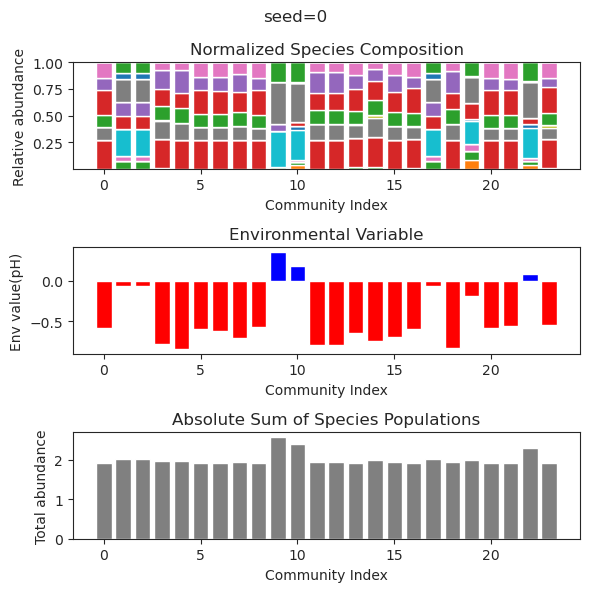

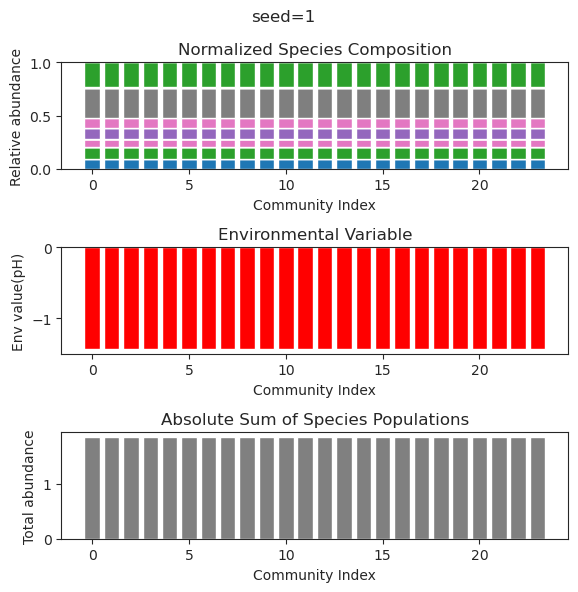

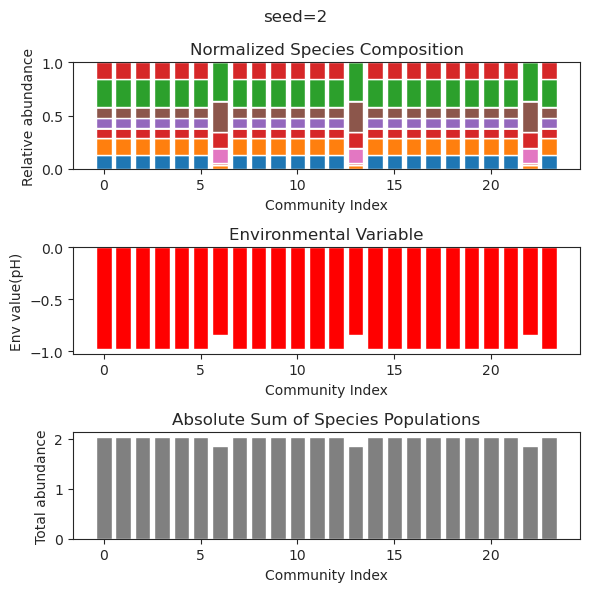

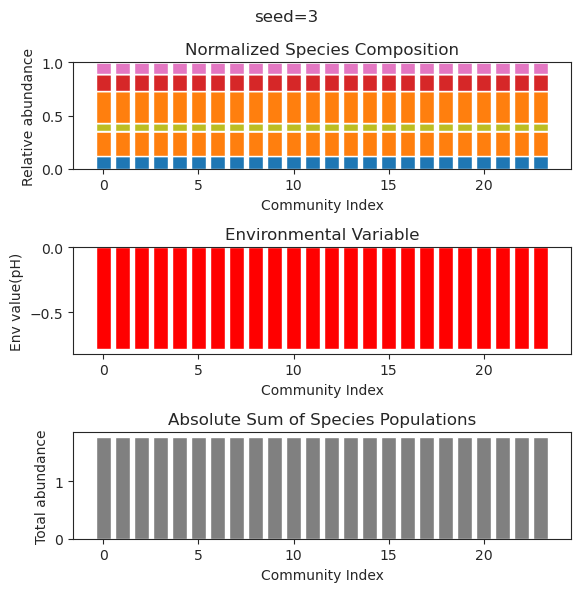

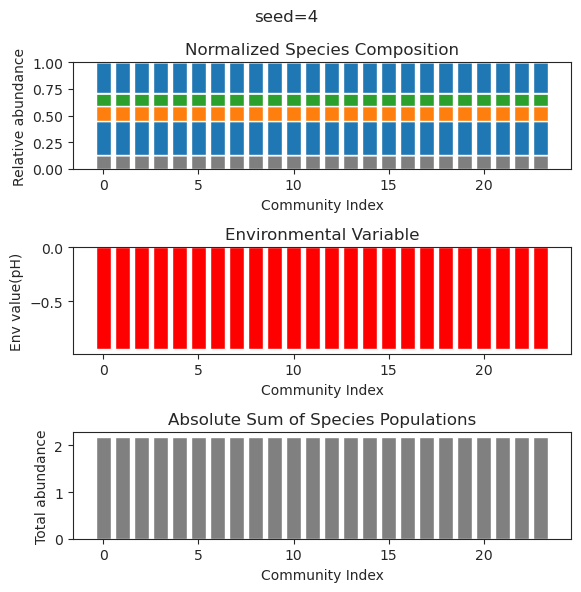

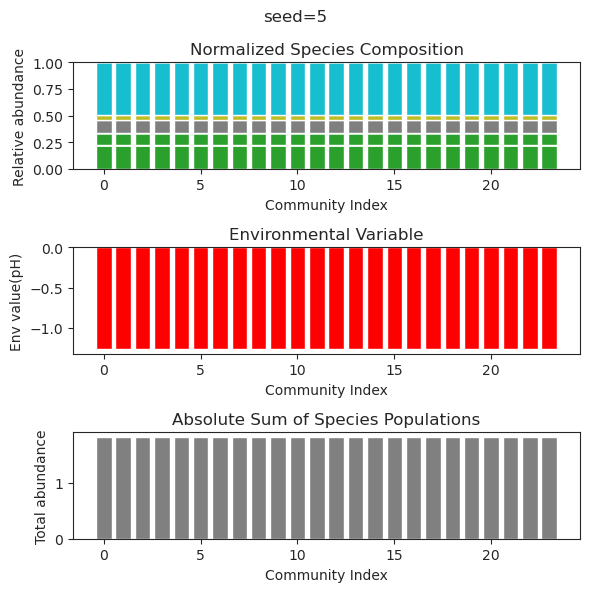

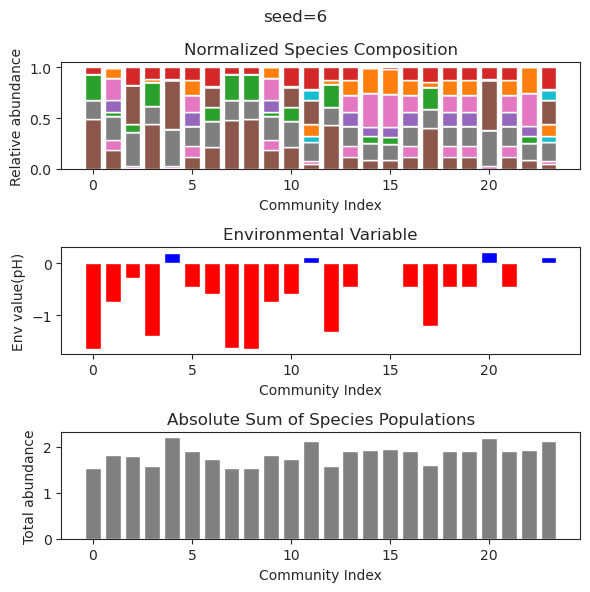

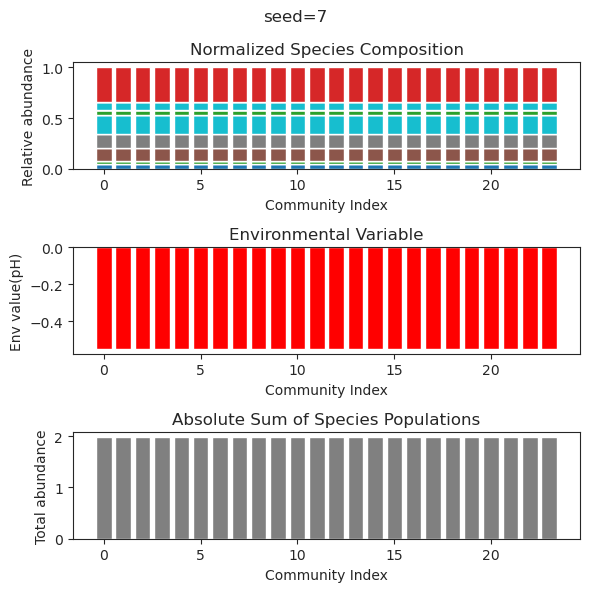

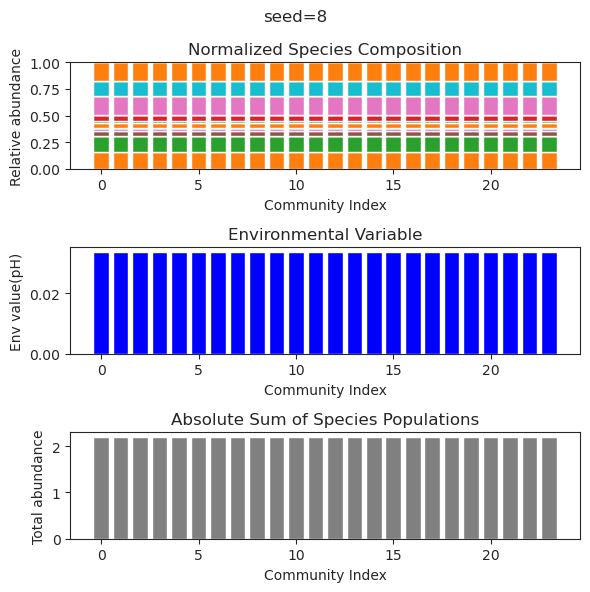

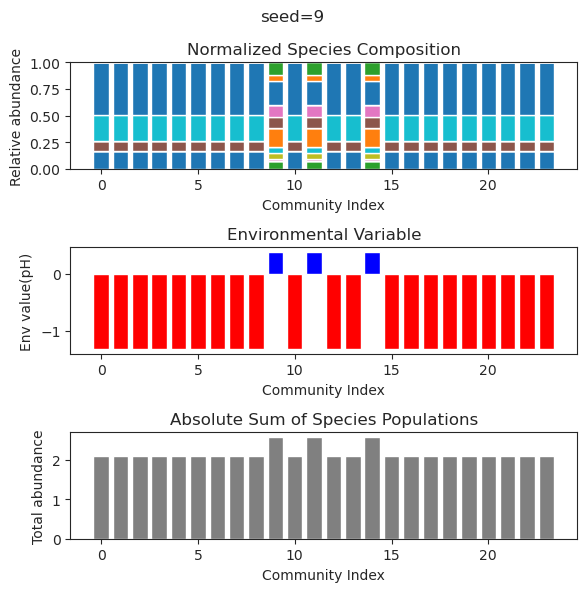

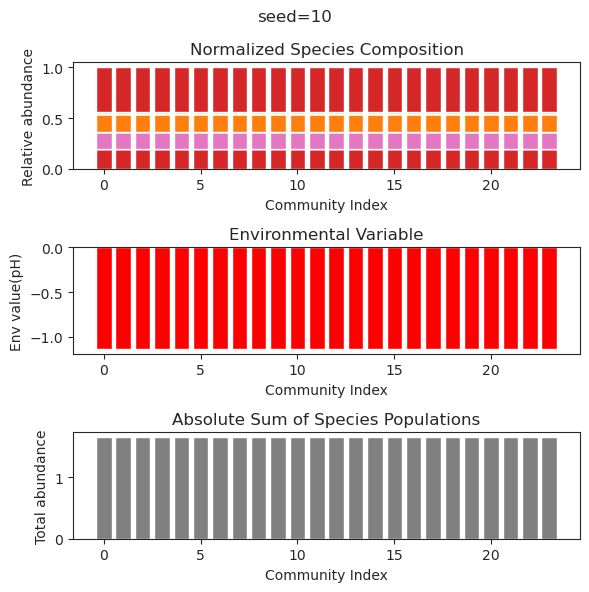

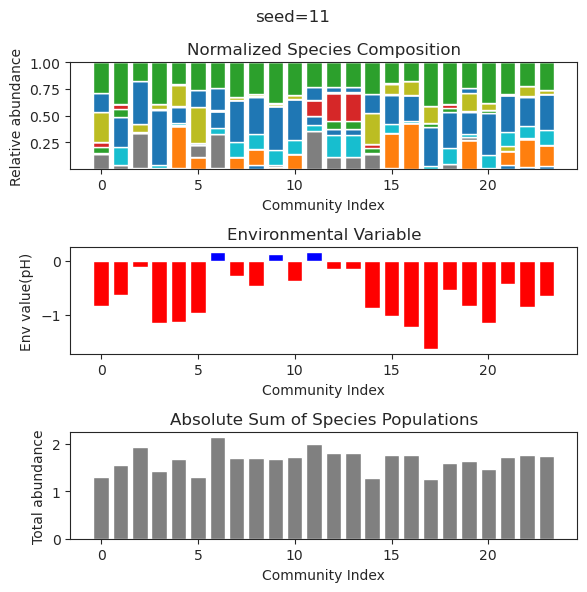

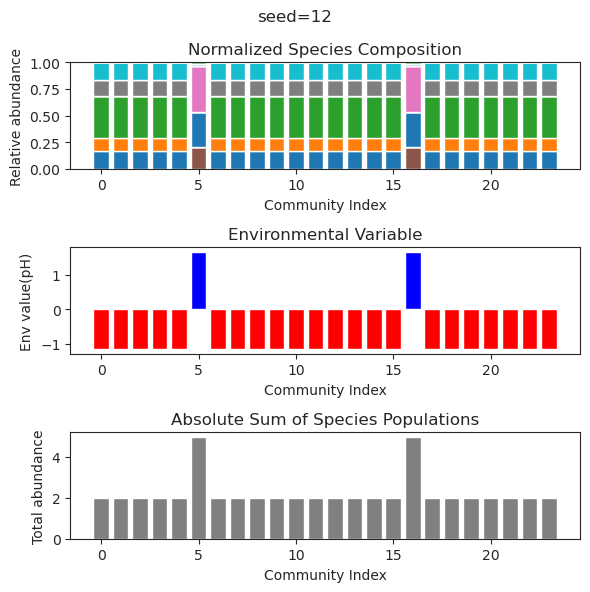

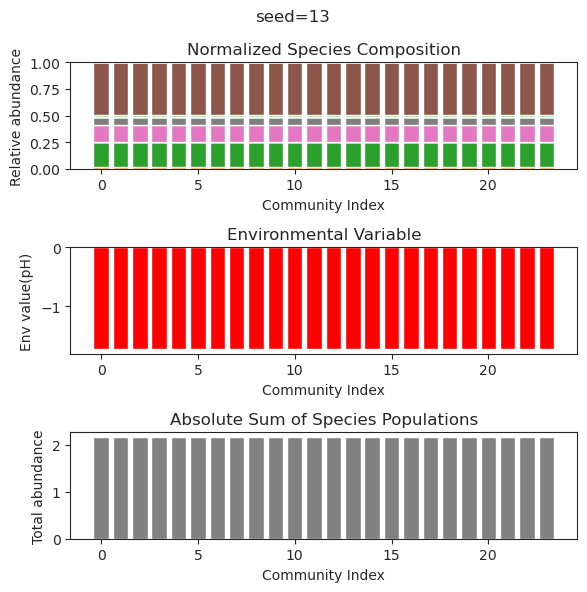

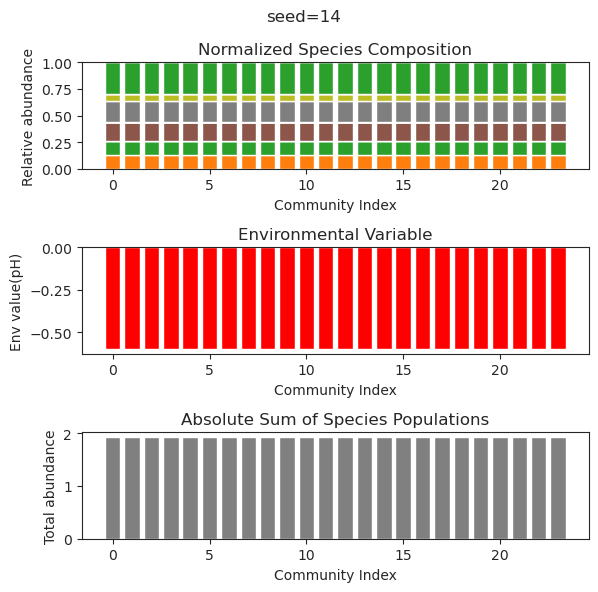

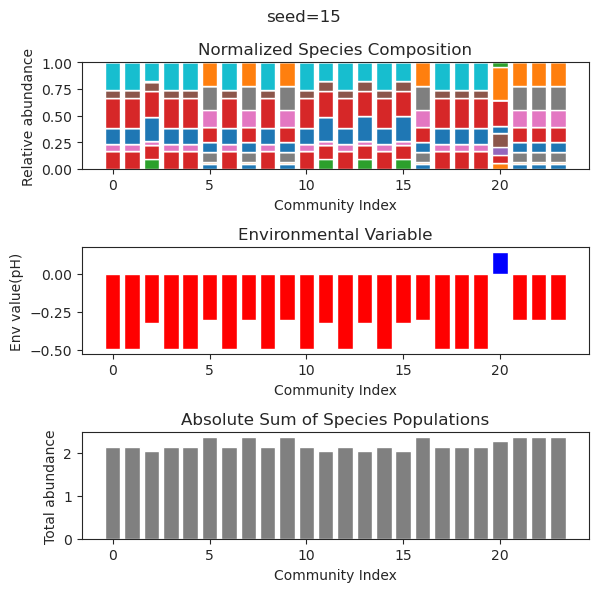

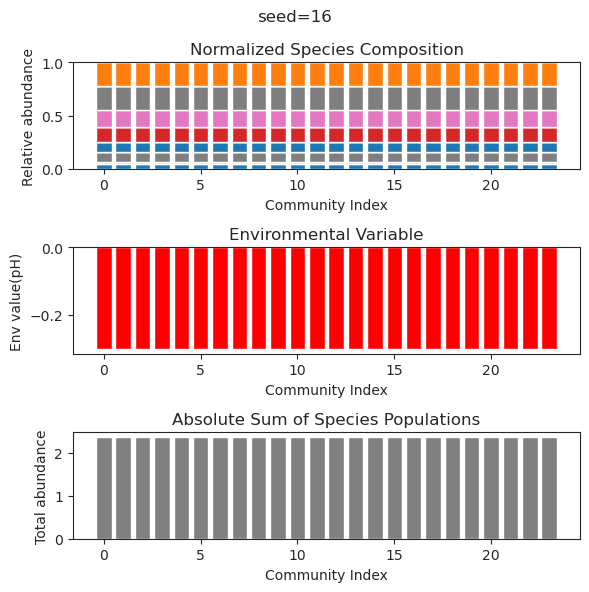

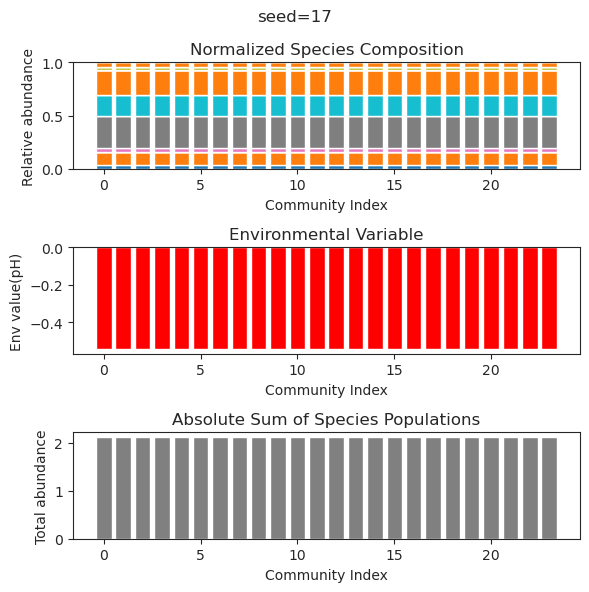

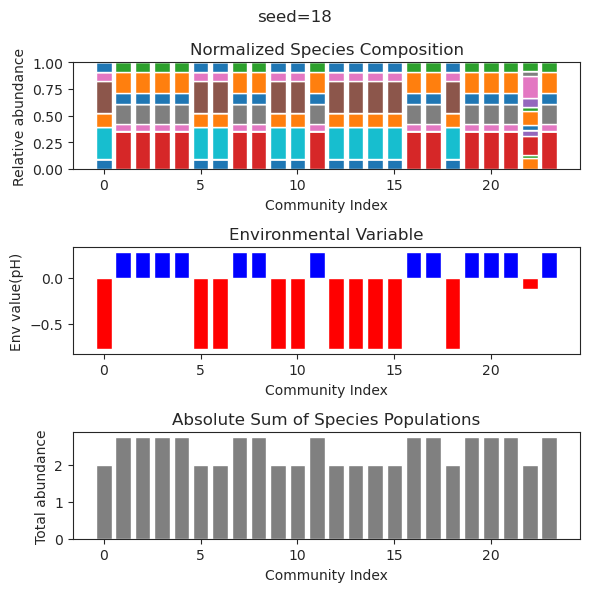

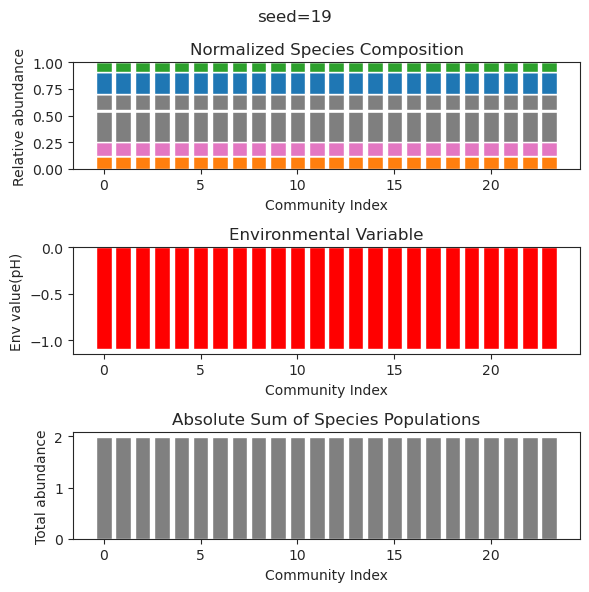

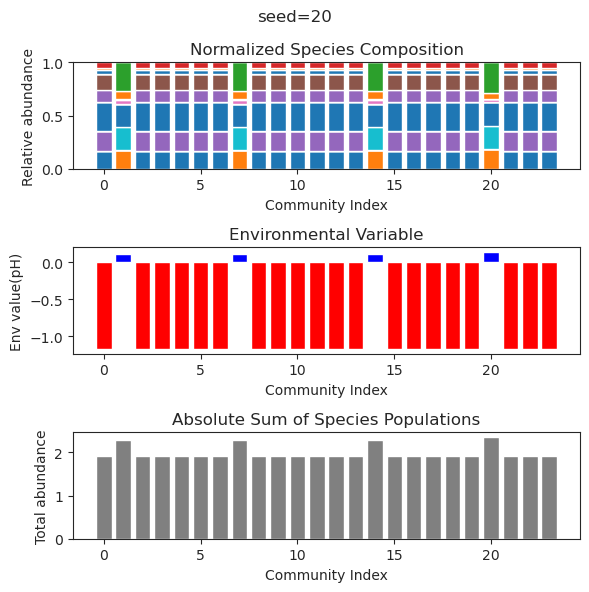

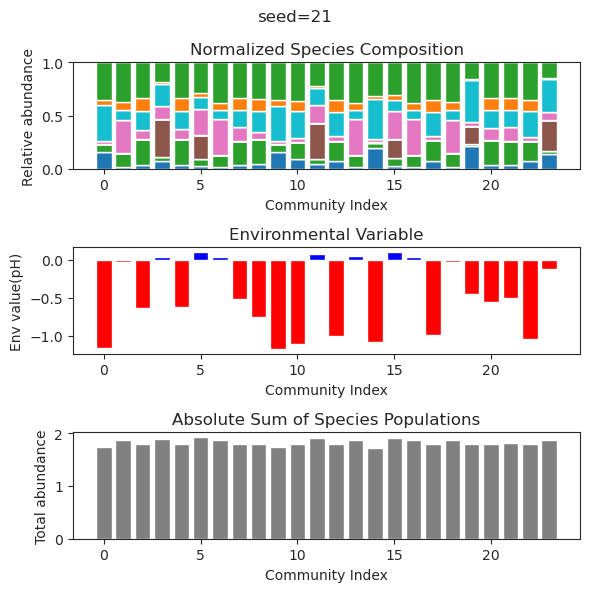

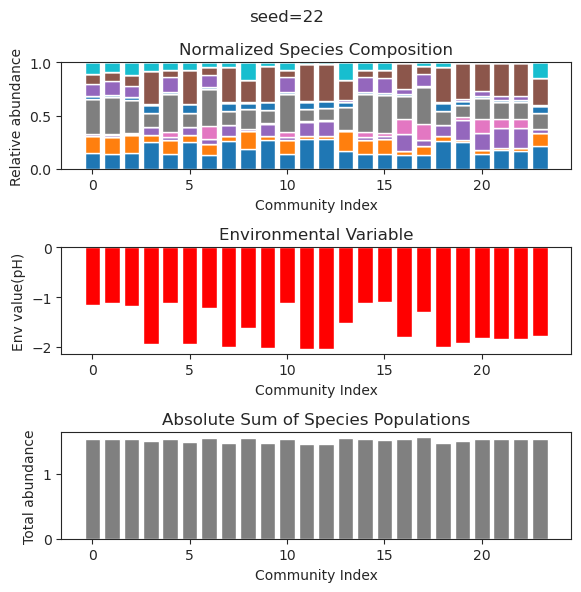

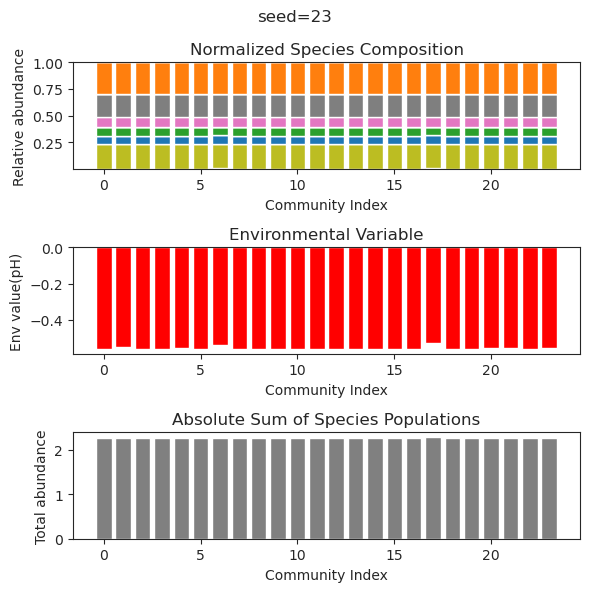

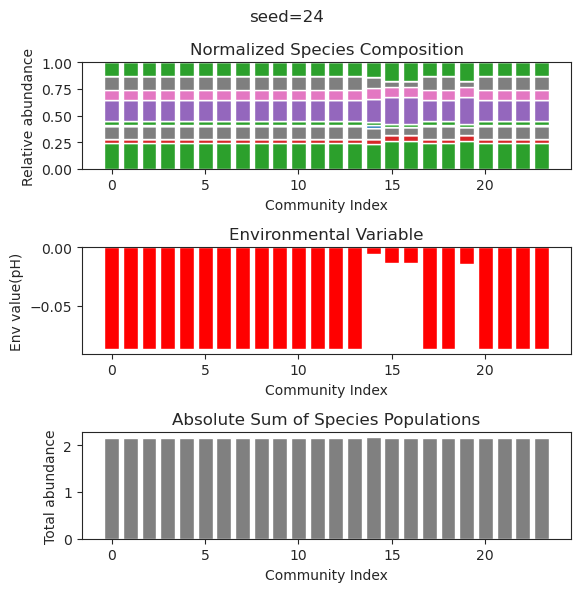

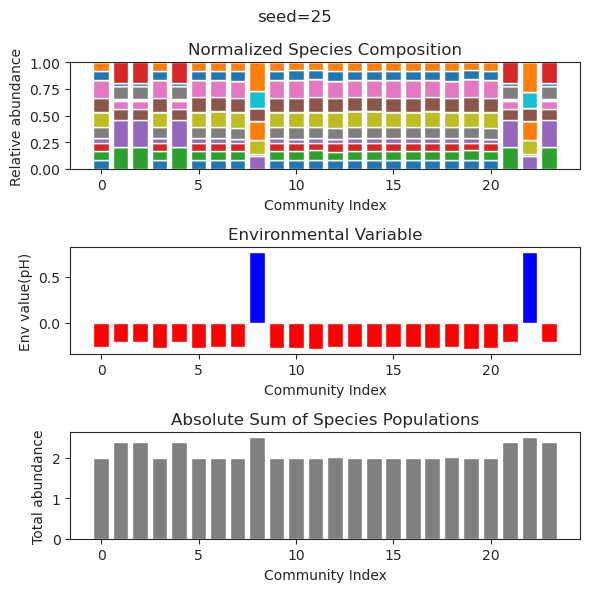

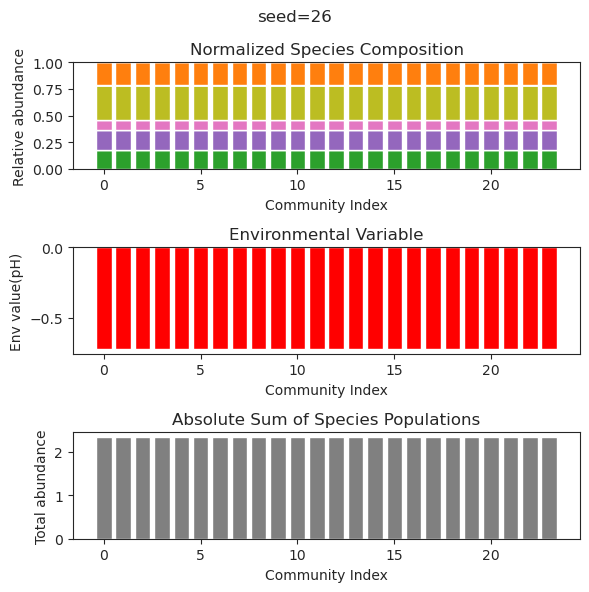

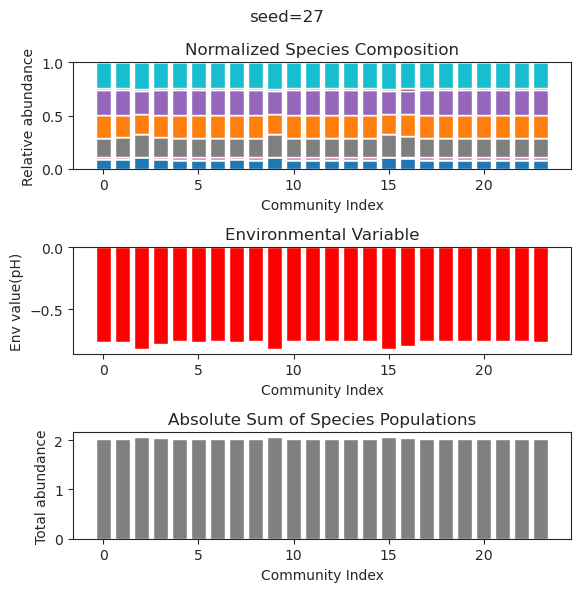

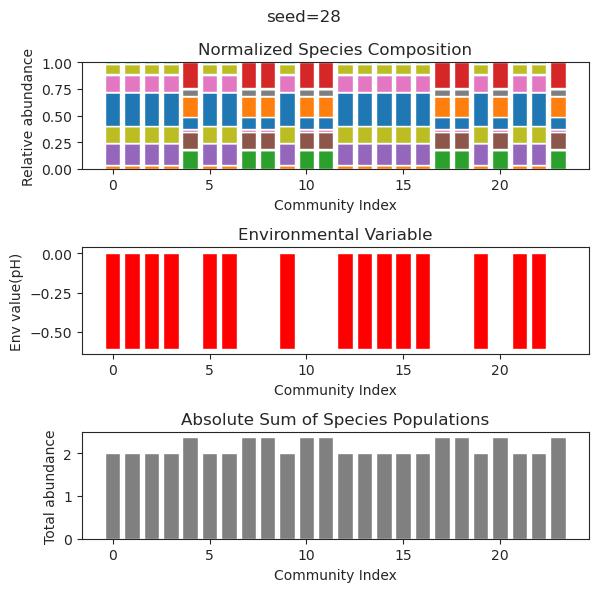

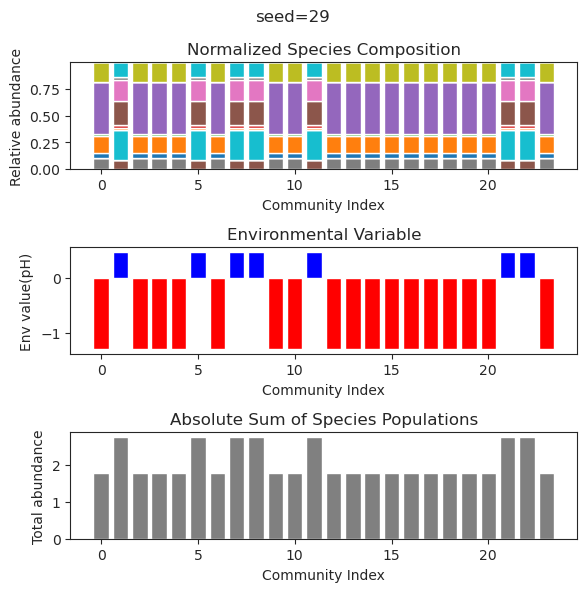

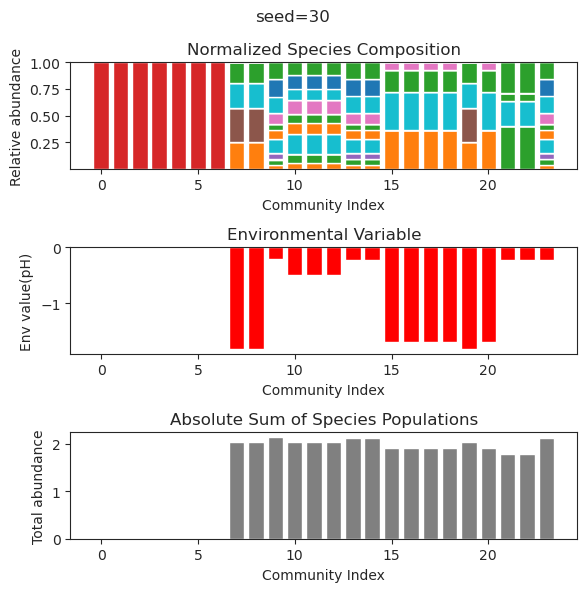

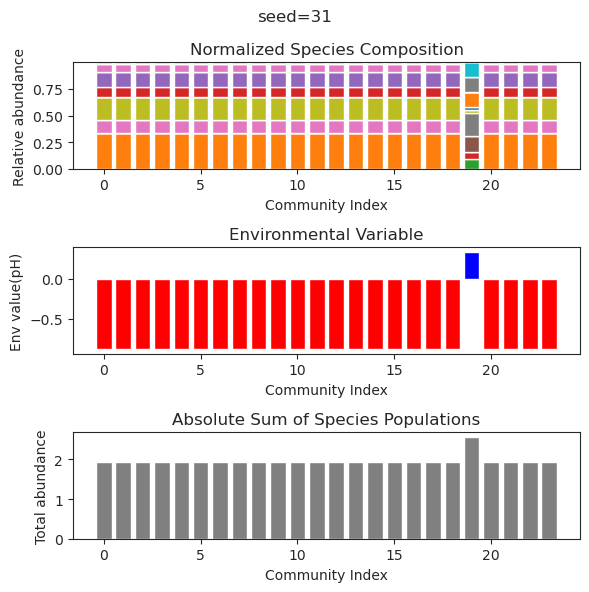

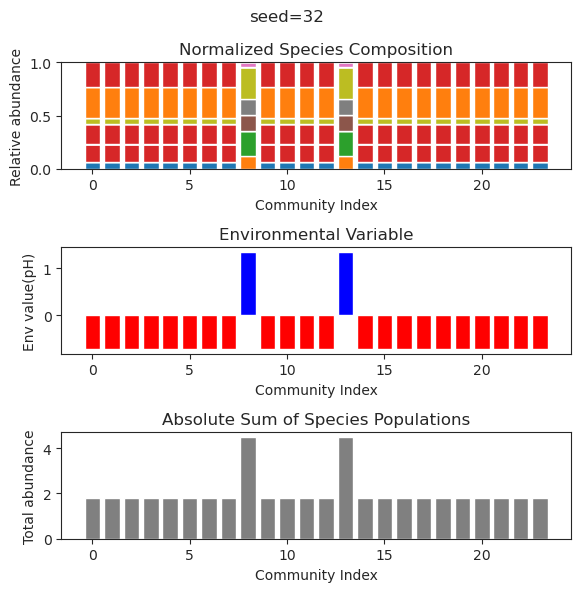

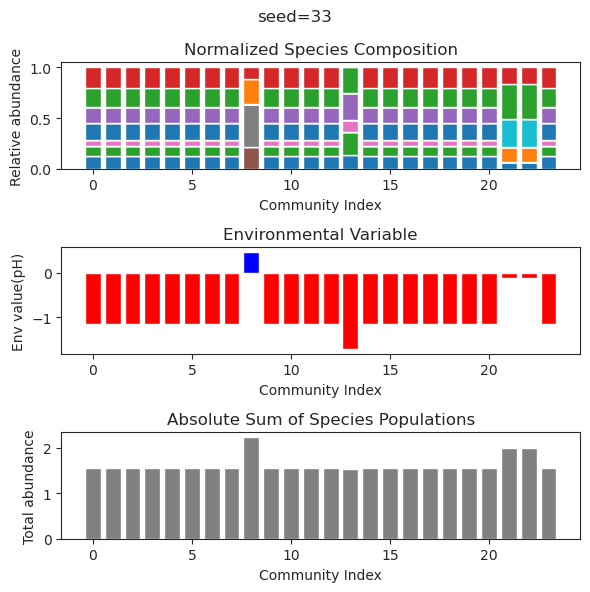

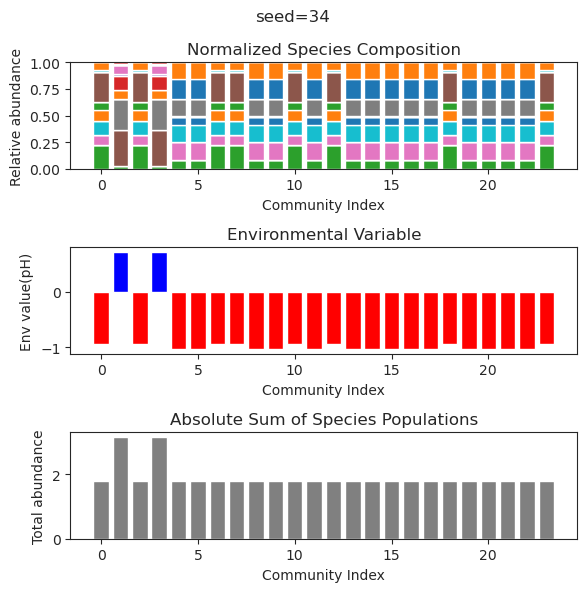

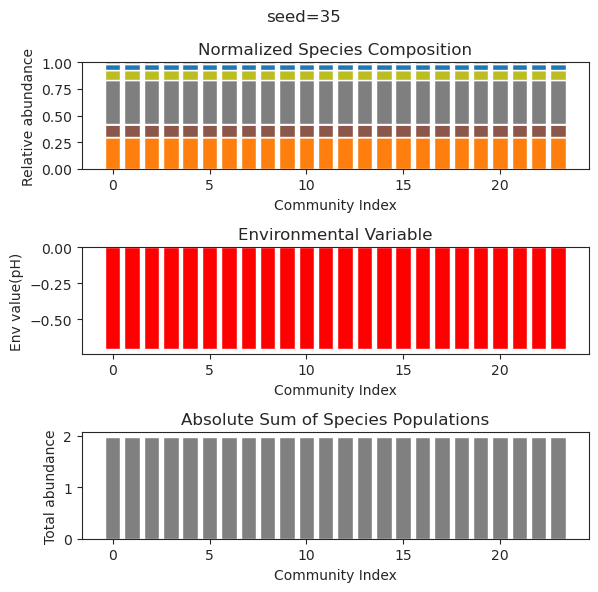

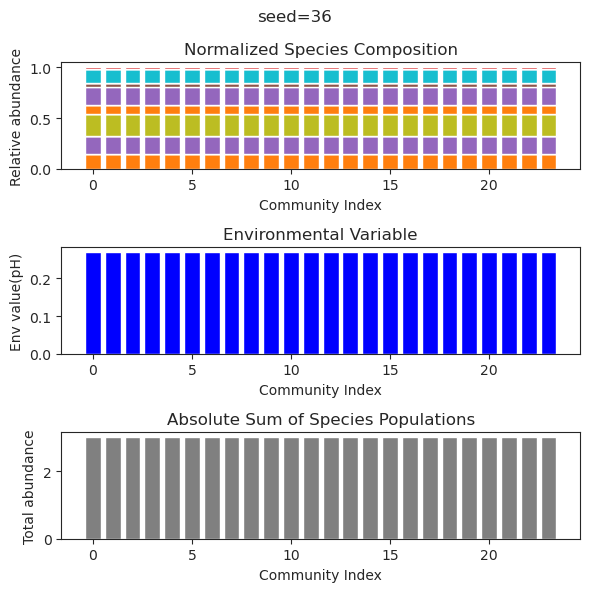

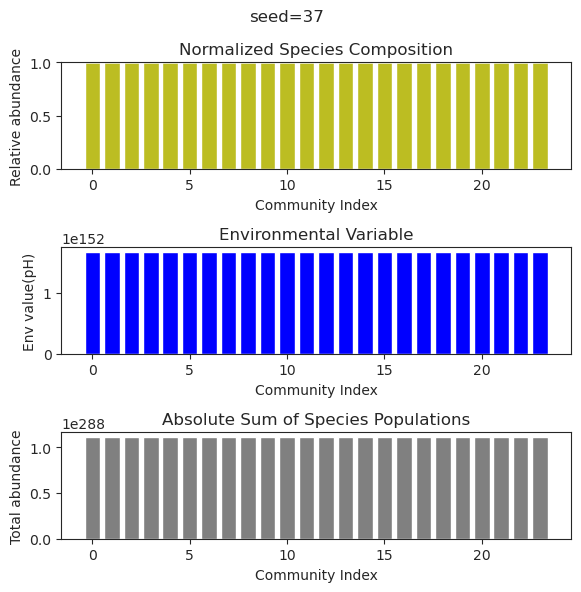

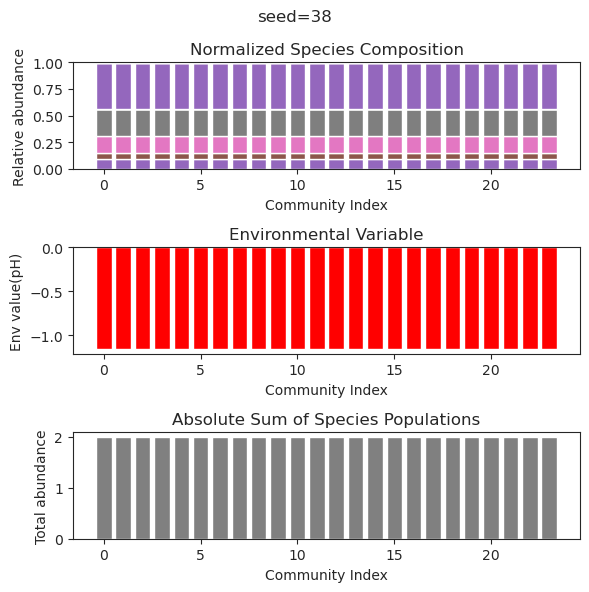

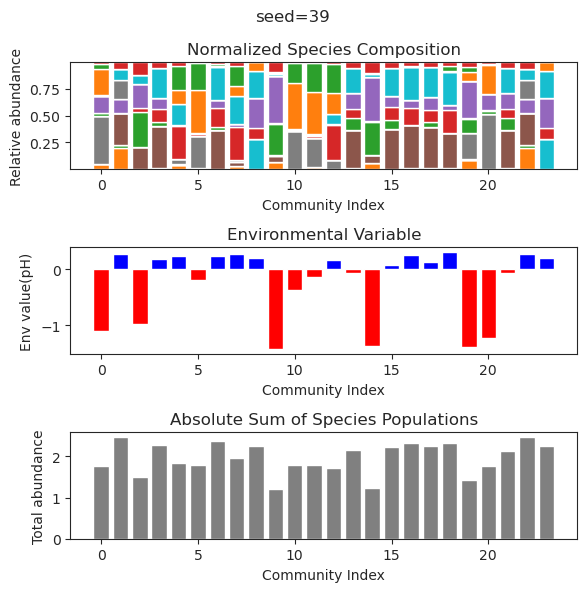

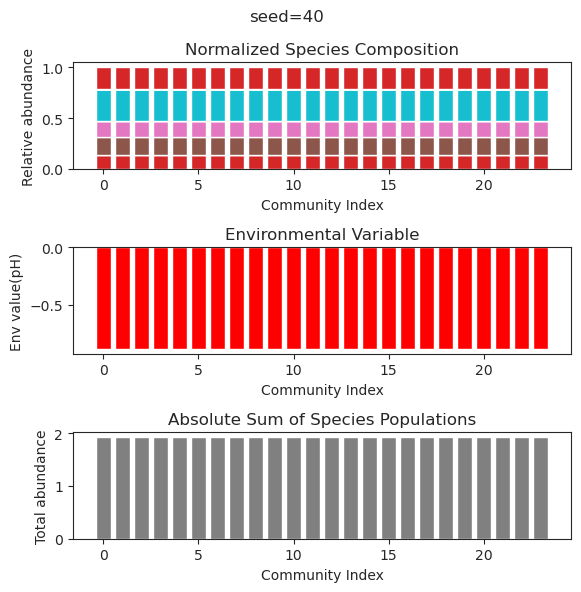

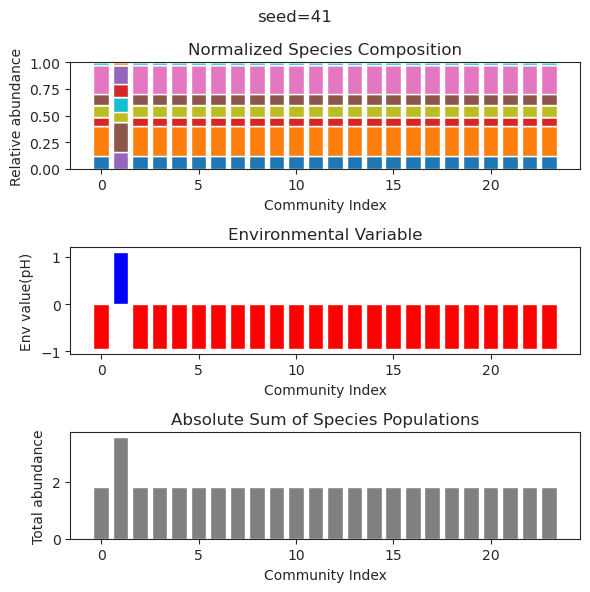

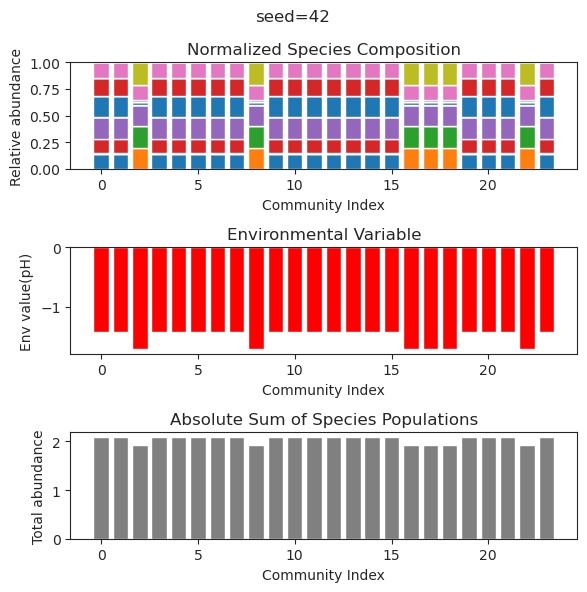

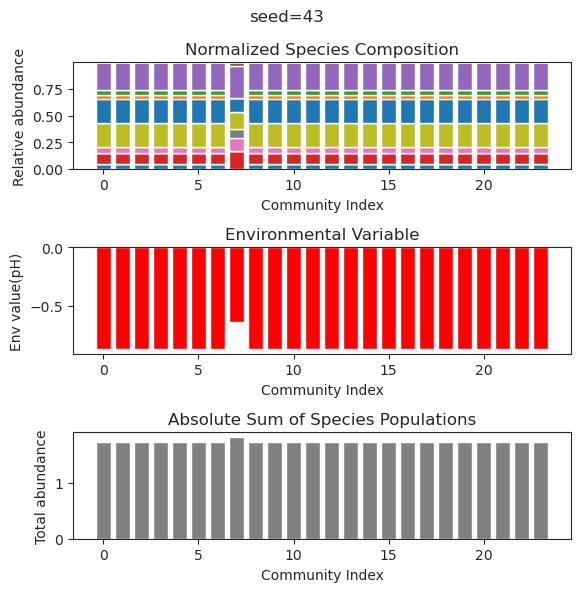

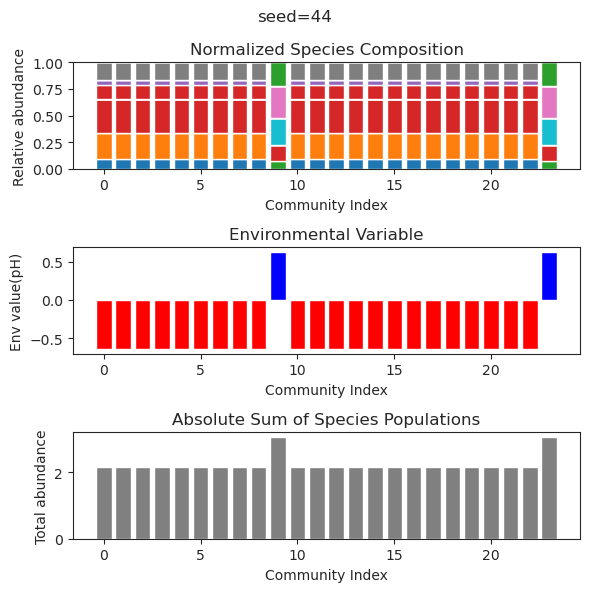

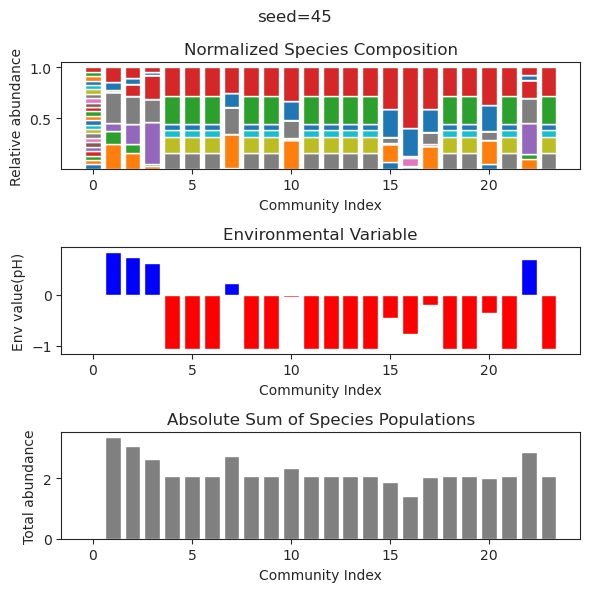

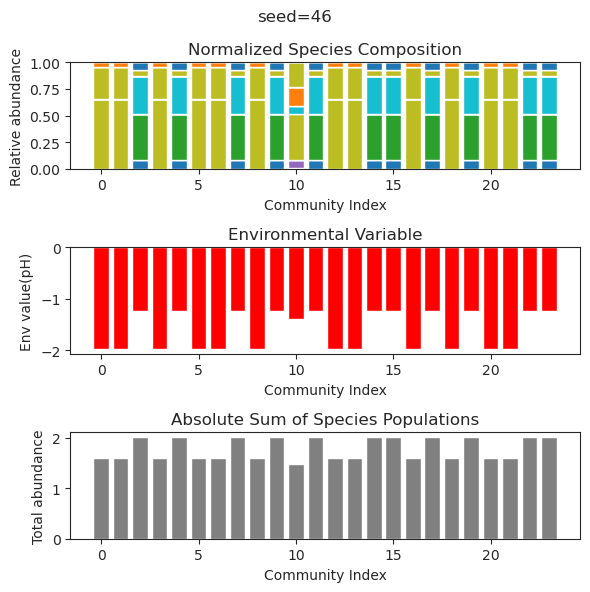

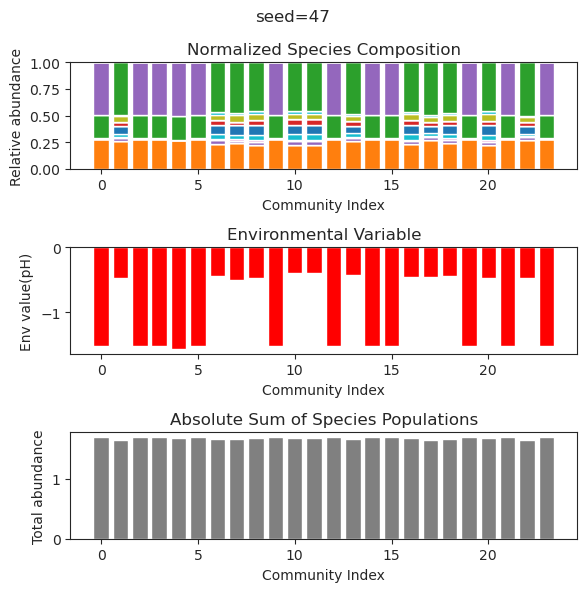

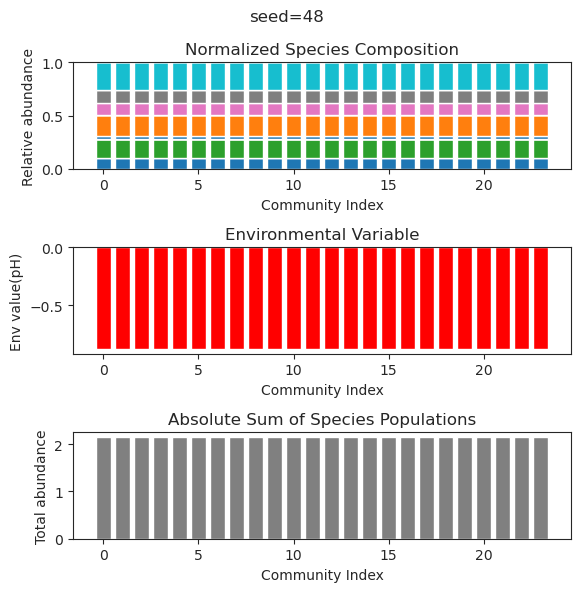

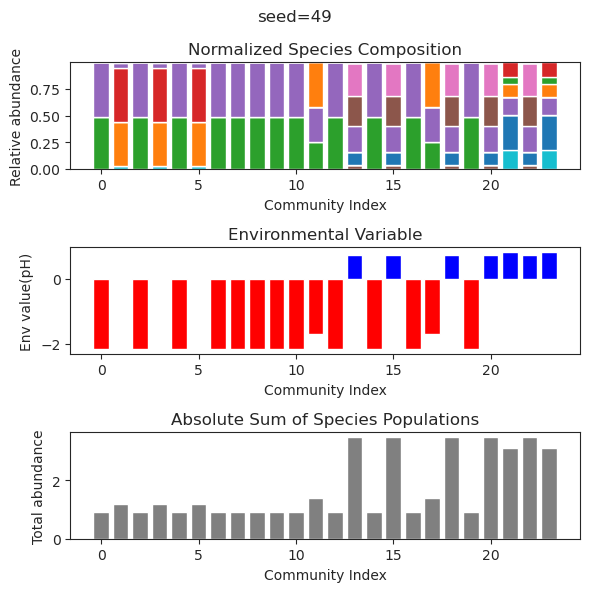

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.integrate import odeint
import pickle

def generate_config(S, seed_num):
    session_path = f'Data/Results_standard/S{S}'
    if not os.path.isdir(session_path):
        os.mkdir(session_path)

    np.random.seed(seed_num)
    # Functions for uniform distribution
    f_I = lambda: uniform.rvs(0, 1)
    f_g = lambda: np.ones(1)
    f_k = lambda: np.ones(1)
    f_p = lambda: uniform.rvs(-0.2, 1.2)
    f_q = lambda: uniform.rvs(-0.2, 1.2)
    f_beta = lambda: np.ones(1)
    N = S
    N_env = 1

    # Initialize I, g, k
    I = np.array([[f_I() for _ in range(N)] for _ in range(N)])
    np.fill_diagonal(I, 1)
    g = np.array([f_g()[0] for _ in range(N)])
    k = np.array([f_k()[0] for _ in range(N)])

    # Initialize p and q
    p = np.array([[f_p() for _ in range(N)] for _ in range(N_env)])
    q = np.array([[f_q() for _ in range(N_env)] for _ in range(N)])

    # Set p=-10 and q=0.2 for one species out of every 6
    for i in range(0, N, 6):
        p[0, i] = -10
        q[i, 0] = 0.2

    beta = np.array([f_beta()[0] for _ in range(N_env)])
    delta = 0.1  # ln(100000)/24 ~= 0.5 per hour
    migration_rate = 0  # 1e-7

    system_config = {
        'I': I,
        'g': g,
        'k': k,
        'p': p,
        'q': q,
        'beta': beta,
        'delta': delta,
        'migration_rate': migration_rate,
        'N': N,
        'N_env': N_env,
        'seed_num': seed_num,
    }

    return system_config, session_path

def one_hot_vector(n_species,i):
    # Create an array of length n_species with all values set to 0.001
    vector = np.full(n_species, 0.0001)
    
    # Set the ith element to 0.1
    vector[i] = 0.01
    
    return vector

def run_analysis(S):
    simulated_result={}
    for seed_num in range(50):

        system_config, session_path = generate_config(S, seed_num)
        
        # Modify beta
        system_config['beta'] = np.array([0.5]) * system_config['delta']
        
        y_out_list = []
        for i in range(S):
            species_index = np.arange(0, S)
            env_index = np.array([0])
            y0_species = one_hot_vector(S, i)
            y0_env = [0]
            t = np.linspace(0, 2000, 10000)
            y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=False)
            y_out_list.append(y_out)

        num_datasets = len(y_out_list)
        
        # Prepare data for plots
        species_matrix = np.array([y_out['species'] for y_out in y_out_list])
        env_data = np.array([y_out['env'][0] for y_out in y_out_list])
        
        # Normalize species data
        species_matrix = np.maximum(species_matrix, 0)
        species_sums = np.sum(species_matrix, axis=1, keepdims=True)
        normalized_species = species_matrix / species_sums
        
        # Absolute sums of species data
        absolute_sums = np.sum(species_matrix, axis=1)
        
        # Create plots
        fig, axs = plt.subplots(3, 1, figsize=(6, 6))
        plt.suptitle(f'seed={system_config["seed_num"]}')
        
        # Plot normalized species composition
        bottom_values = np.zeros(num_datasets)
        for i in range(normalized_species.shape[1]):
            axs[0].bar(np.arange(num_datasets), normalized_species[:, i], bottom=bottom_values, label=f'Species {i+1}')
            bottom_values += normalized_species[:, i]
        axs[0].set_title('Normalized Species Composition')
        axs[0].set_xlabel('Community Index')
        axs[0].set_ylabel('Relative abundance')
        
        # Plot environmental factors
        colors = ['blue' if x > 0 else 'red' for x in env_data]
        axs[1].bar(np.arange(num_datasets), env_data, color=colors, width=0.8)
        axs[1].set_title('Environmental Variable')
        axs[1].set_xlabel('Community Index')
        axs[1].set_ylabel('Env value(pH)')
        
        # Plot absolute sums of species data
        axs[2].bar(np.arange(num_datasets), absolute_sums, color='gray', width=0.8)
        axs[2].set_title('Absolute Sum of Species Populations')
        axs[2].set_xlabel('Community Index')
        axs[2].set_ylabel('Total abundance')
        
        plt.tight_layout()
        plt.savefig(session_path + f'/diagram_{system_config["seed_num"]}.png')
        #plt.close()

        # Prepare data to save
        simulated_result[system_config['seed_num']]= {'species': species_matrix, 'env': env_data}
        
        description = f"Analysis for S={S} species"

    data_to_save = {
        'result': simulated_result,
        'description': description
    }
    
    # Save to pickle file
    with open(session_path + '/result_and_description.pkl', 'wb') as file:
        pickle.dump(data_to_save, file)
# Run analysis for each S value

for S in [24]:
    run_analysis(S)
    print(f"Completed analysis for S={S}")


In [10]:

    with open('Data/Results_standard/S6'+'/result_and_description.pkl', 'rb') as file:
        # Load the data from the file
        data = pickle.load(file)

Classification 1: Indices [1, 2, 6, 7, 9, 10, 11, 13, 15, 16, 18, 19]
Classification 2: Indices [0, 3, 4, 5, 8, 12, 14, 17]
Classification 3: Indices []
Classification 4: Indices []
Classification 5: Indices []


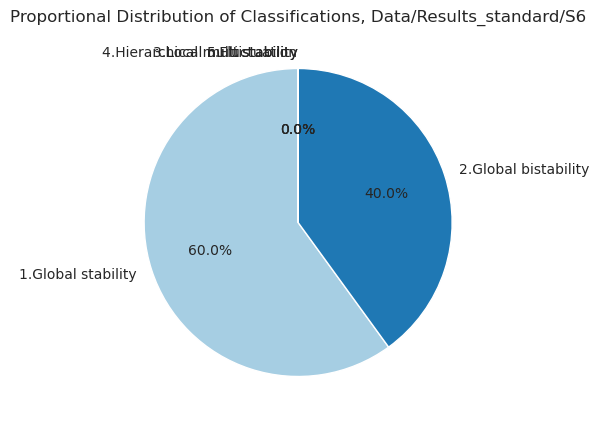

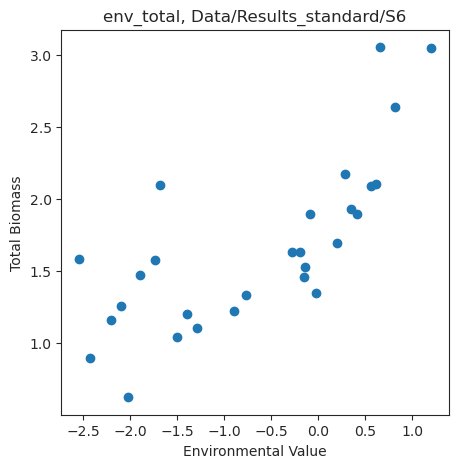

Classification 1: Indices [0, 2, 3, 6, 8, 9, 10, 11, 12, 15, 16]
Classification 2: Indices [5, 7, 14, 17, 18]
Classification 3: Indices [4, 13, 19]
Classification 4: Indices []
Classification 5: Indices [1]


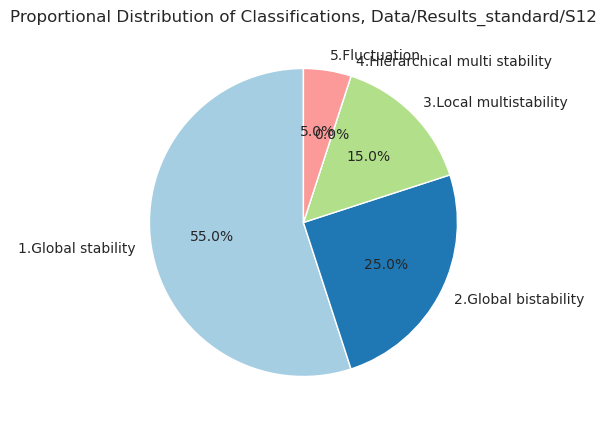

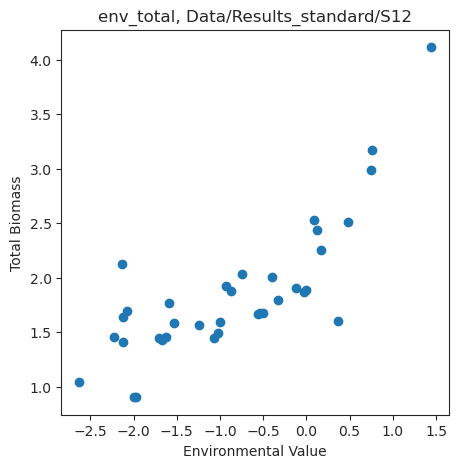

Classification 1: Indices [2, 3, 7, 8, 11, 13, 14, 15, 16, 17, 18]
Classification 2: Indices [1, 4, 10]
Classification 3: Indices [9, 12]
Classification 4: Indices []
Classification 5: Indices [0, 5, 6, 19]


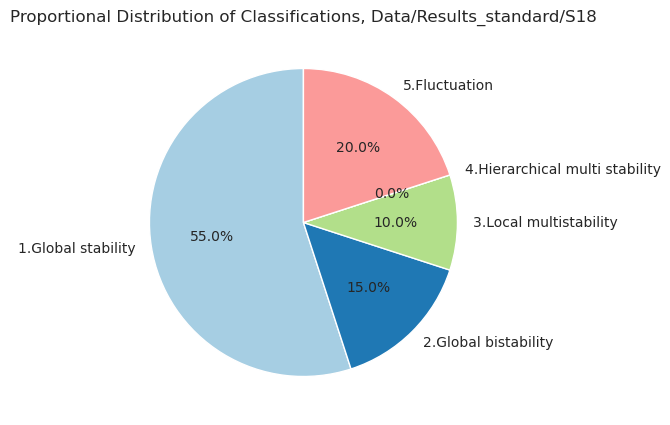

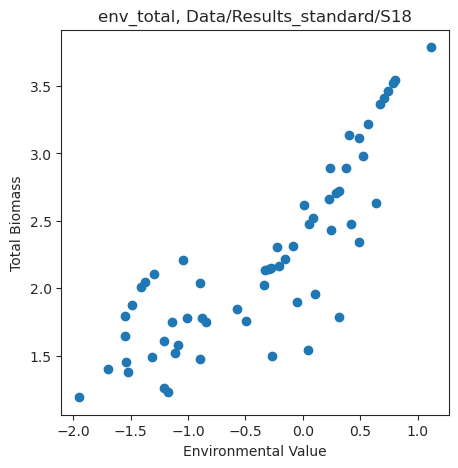

Classification 1: Indices [1, 3, 4, 5, 7, 8, 10, 13, 14, 17, 19]
Classification 2: Indices [9, 12]
Classification 3: Indices [2, 16]
Classification 4: Indices [15, 18]
Classification 5: Indices [0, 6, 11]


/tmp/ipykernel_2753680/198715494.py:26: RuntimeWarning: invalid value encountered in scalar subtract
  if sorted_data[i] - sorted_data[i - 1] < threshold:


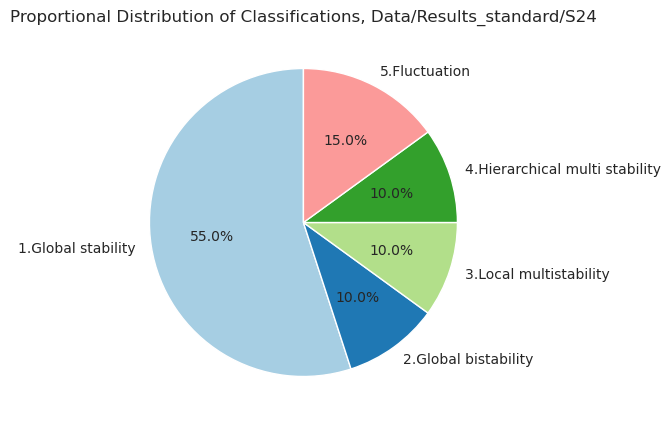

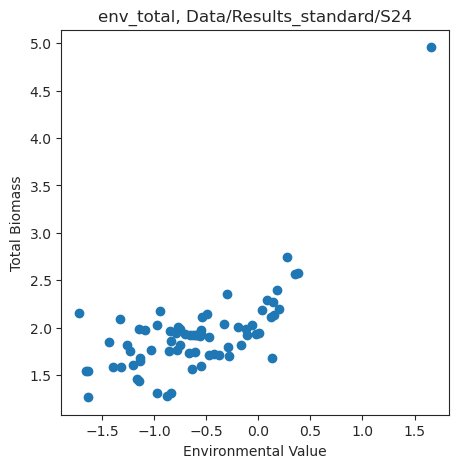

In [20]:
Session_name_list=[f'Data/Results_standard/S{S}'for S in [6,12,18,24]]

for Session_name in Session_name_list:
    # Open the file in binary read mode
    with open(Session_name + '/result_and_description.pkl', 'rb') as file:
        # Load the data from the file
        data = pickle.load(file)

    # Now you can use the 'data' object as it was originally saved
    results = data['result']
    description = data['description']

    def cluster_env_values(data, threshold):
        # Sort the data and store the original indices
        indices = np.argsort(data)
        sorted_data = data[indices]

        # Initialize the first cluster
        clusters = []
        cluster_indices = []
        current_cluster = [sorted_data[0]]
        current_indices = [indices[0]]

        # Iterate over the sorted data to form clusters
        for i in range(1, len(sorted_data)):
            if sorted_data[i] - sorted_data[i - 1] < threshold:
                # Add to the current cluster
                current_cluster.append(sorted_data[i])
                current_indices.append(indices[i])
            else:
                # Save the current cluster and start a new one
                clusters.append(current_cluster)
                cluster_indices.append(current_indices)
                current_cluster = [sorted_data[i]]
                current_indices = [indices[i]]

        # Add the last cluster
        clusters.append(current_cluster)
        cluster_indices.append(current_indices)

        return clusters, cluster_indices

    def filter_env_values(clustered_values, cluster_indices, threshold):
        filtered_values = []
        filtered_indices = []
        for values, indices in zip(clustered_values, cluster_indices):
            temp_values = [value for value in values if -threshold <= value <= threshold]
            temp_indices = [indices[i] for i, value in enumerate(values) if -threshold <= value <= threshold]
            if temp_values:
                filtered_values.append(temp_values)
                filtered_indices.append(temp_indices)
        return filtered_values, filtered_indices

    def classifier(species_matrix, env_data):
        env_clusters, cluster_indices = cluster_env_values(env_data, 0.01)
        env_clusters, cluster_indices = filter_env_values(env_clusters, cluster_indices, 20)
        flattened_values = [item for sublist in env_clusters for item in sublist]
        flattened_values = np.array(flattened_values)
        if len(env_clusters) > 4:
            return 5
        if len(env_clusters) == 1:
            return 1
        if np.all(flattened_values > 0) or np.all(flattened_values < 0):
            return 3
        if len(env_clusters) == 2:
            return 2
        if len(env_clusters) == 3 or len(env_clusters) == 4:
            return 4

    classification_indices = {1: [], 2: [], 3: [], 4: [], 5: []}
    total_biomasses = []
    env_values = []

    # Iterate over results and classify
    for key, value in results.items():
        species_matrix = value['species']
        env_data = value['env']
        env_clusters, cluster_indices = cluster_env_values(env_data, 0.01)
        env_clusters, cluster_indices = filter_env_values(env_clusters, cluster_indices, 20)
        classification = classifier(species_matrix, env_data)
        classification_indices[classification].append(key)

        total_biomasses += [species_matrix.sum(1)[cluster_indice[0]] for cluster_indice in cluster_indices]
        env_values += [env_data[cluster_indice[0]] for cluster_indice in cluster_indices]

    # Print classification results
    for cls, idxs in classification_indices.items():
        print(f"Classification {cls}: Indices {idxs}")

    def plot_classification_pie_chart(classification_indices, Session_name, to_save=True):
        counts = [len(indices) for indices in classification_indices.values()]
        class_labels = ["1.Global stability", "2.Global bistability", "3.Local multistability", "4.Hierarchical multi stability", "5.Fluctuation"]

        plt.figure(figsize=(5, 5))
        plt.pie(counts, labels=class_labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired(range(len(counts))))    
        plt.title(f'Proportional Distribution of Classifications, {Session_name}')
        if to_save:
            plt.savefig(f'{Session_name}/pyplot_classes.png')
        plt.show()

    def plot_env_total(env_values, total_biomasses, Session_name, to_save=True):
        plt.figure(figsize=(5, 5))
        plt.scatter(env_values, total_biomasses)
        plt.title(f'env_total, {Session_name}')
        plt.xlabel('Environmental Value')  # Adding x-axis label
        plt.ylabel('Total Biomass')  # Adding y-axis label
        if to_save:
            plt.savefig(f'{Session_name}/plot_env_total.png')
        plt.show()

    plot_classification_pie_chart(classification_indices, Session_name, to_save=True)
    plot_env_total(env_values, total_biomasses, Session_name, to_save=True)

In [24]:
proportions = species_matrix / np.sum(species_matrix, axis=1, keepdims=True)
np.apply_along_axis(entropy, 1, proportions)

array([[5.26209118e-061, 1.15026880e-001, 4.39074157e-052,
        0.00000000e+000, 9.18497351e-028, 1.30247972e-045,
        1.32648755e-001, 2.94946038e-001, 4.00469324e-073,
        0.00000000e+000, 0.00000000e+000, 3.97995301e-054,
        8.25277715e-049, 2.79164381e-073, 1.34490618e-002,
        1.23692314e-070, 6.45048010e-044, 1.42252430e-001,
        0.00000000e+000, 2.60702698e-071, 2.15428046e-001,
        0.00000000e+000, 8.62487877e-002, 3.24139963e-022],
       [0.00000000e+000, 1.15026880e-001, 2.47237836e-054,
        9.81330867e-067, 2.50947474e-029, 8.25710805e-058,
        1.32648755e-001, 2.94946038e-001, 9.32743910e-068,
        0.00000000e+000, 0.00000000e+000, 9.58500187e-050,
        0.00000000e+000, 6.41063767e-069, 1.34490618e-002,
        1.36759466e-061, 0.00000000e+000, 1.42252430e-001,
        0.00000000e+000, 1.73701546e-063, 2.15428046e-001,
        2.55988423e-027, 8.62487877e-002, 0.00000000e+000],
       [1.41435886e-057, 1.15026880e-001, 1.02545168e-

In [34]:
diversities = calculate_diversity(species_matrix, 1e-3)
diversities 

[[14,
  7,
  6,
  12,
  22,
  15,
  5,
  10,
  21,
  8,
  0,
  23,
  4,
  13,
  17,
  19,
  20,
  3,
  11,
  2,
  9,
  1,
  18,
  16]]

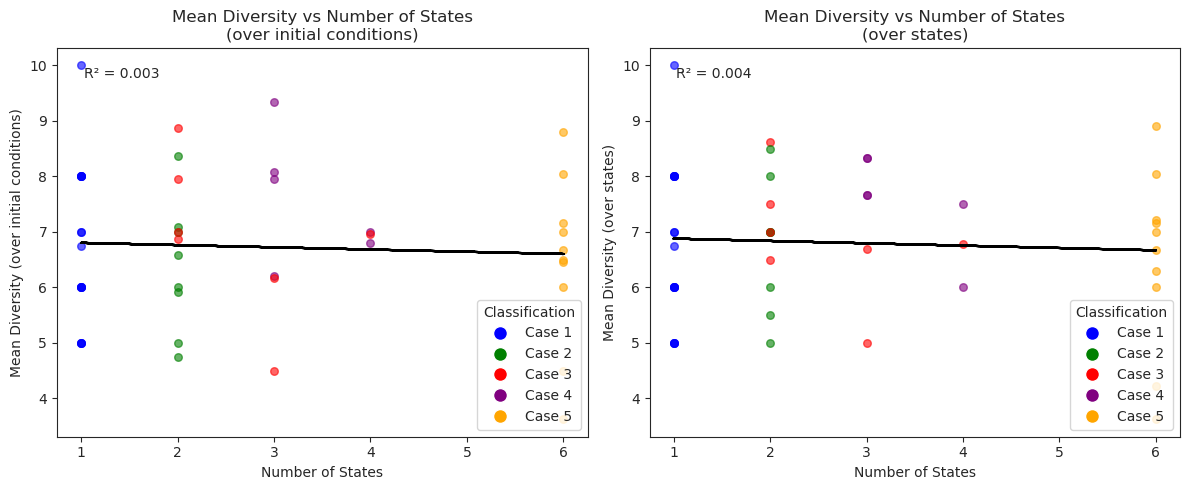

[{'num_states': 6, 'mean_div_initial': 7.166666666666667, 'mean_div_states': 7.166666666666667, 'classification': 5}, {'num_states': 1, 'mean_div_initial': 8.0, 'mean_div_states': 8.0, 'classification': 1}, {'num_states': 2, 'mean_div_initial': 6.875, 'mean_div_states': 6.5, 'classification': 3}, {'num_states': 1, 'mean_div_initial': 6.75, 'mean_div_states': 6.75, 'classification': 1}, {'num_states': 1, 'mean_div_initial': 5.0, 'mean_div_states': 5.0, 'classification': 1}, {'num_states': 1, 'mean_div_initial': 5.0, 'mean_div_states': 5.0, 'classification': 1}, {'num_states': 6, 'mean_div_initial': 6.666666666666667, 'mean_div_states': 6.666666666666667, 'classification': 5}, {'num_states': 1, 'mean_div_initial': 8.0, 'mean_div_states': 8.0, 'classification': 1}, {'num_states': 1, 'mean_div_initial': 10.0, 'mean_div_states': 10.0, 'classification': 1}, {'num_states': 2, 'mean_div_initial': 4.75, 'mean_div_states': 7.0, 'classification': 2}, {'num_states': 1, 'mean_div_initial': 5.0, 'me

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

Session_name = 'Data/Results_standard/S24'

def calculate_diversity(species_matrix, threshold=1e-3):
    return np.sum(species_matrix > threshold, axis=1)

def mean_diversity_over_initial_conditions(species_matrix, threshold=1e-3):
    diversities = calculate_diversity(species_matrix, threshold)
    return np.mean(diversities)

def mean_diversity_over_states(species_matrix, cluster_indices, threshold=1e-3):
    diversities = calculate_diversity(species_matrix, threshold)
    state_diversities = [np.mean(diversities[indices]) for indices in cluster_indices]
    return np.mean(state_diversities)

def classifier(species_matrix, env_data):
    env_clusters, cluster_indices = cluster_env_values(env_data, 0.01)
    env_clusters, cluster_indices = filter_env_values(env_clusters, cluster_indices, 20)
    flattened_values = [item for sublist in env_clusters for item in sublist]
    flattened_values = np.array(flattened_values)
    if len(env_clusters) > 4:
        return 5
    if len(env_clusters) == 1:
        return 1
    if np.all(flattened_values > 0) or np.all(flattened_values < 0):
        return 3
    if len(env_clusters) == 2:
        return 2
    if len(env_clusters) == 3 or len(env_clusters) == 4:
        return 4

all_results = []

with open(Session_name + '/result_and_description.pkl', 'rb') as file:
    data = pickle.load(file)

results = data['result']

for key, value in results.items():
    species_matrix = value['species']
    env_data = value['env']
    
    classification = classifier(species_matrix, env_data)
    
    if classification == 5:
        num_states = 6  # Mark fluctuation cases as having > 5 states
    else:
        env_clusters, cluster_indices = cluster_env_values(env_data, 0.01)
        env_clusters, cluster_indices = filter_env_values(env_clusters, cluster_indices, 20)
        num_states = len(cluster_indices)
    
    mean_div_initial = mean_diversity_over_initial_conditions(species_matrix)
    mean_div_states = mean_diversity_over_states(species_matrix, cluster_indices)
    
    all_results.append({
        'num_states': num_states,
        'mean_div_initial': mean_div_initial,
        'mean_div_states': mean_div_states,
        'classification': classification
    })
    
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Create scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Smaller figure size

colors = ['blue', 'green', 'red', 'purple', 'orange']

# Prepare data for regression
x1, y1 = [], []
x2, y2 = [], []

for result in all_results:
    if not np.isnan(result['num_states']) and not np.isnan(result['mean_div_initial']) and not np.isnan(result['mean_div_states']):
        color = colors[result['classification'] - 1]
        ax1.scatter(result['num_states'], result['mean_div_initial'], c=color, alpha=0.6, s=30)
        ax2.scatter(result['num_states'], result['mean_div_states'], c=color, alpha=0.6, s=30)
        
        # Collect data for regression
        x1.append(result['num_states'])
        y1.append(result['mean_div_initial'])
        x2.append(result['num_states'])
        y2.append(result['mean_div_states'])

# Perform linear regression and plot for ax1
if x1 and y1:
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1, y1)
    line1 = slope1 * np.array(x1) + intercept1
    ax1.plot(x1, line1, color='black', linestyle='--')
    ax1.text(0.05, 0.95, f'R² = {r_value1**2:.3f}', transform=ax1.transAxes, fontsize=10, verticalalignment='top')

# Perform linear regression and plot for ax2
if x2 and y2:
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2, y2)
    line2 = slope2 * np.array(x2) + intercept2
    ax2.plot(x2, line2, color='black', linestyle='--')
    ax2.text(0.05, 0.95, f'R² = {r_value2**2:.3f}', transform=ax2.transAxes, fontsize=10, verticalalignment='top')

ax1.set_xlabel('Number of States')
ax1.set_ylabel('Mean Diversity (over initial conditions)')
ax1.set_title('Mean Diversity vs Number of States\n(over initial conditions)')

ax2.set_xlabel('Number of States')
ax2.set_ylabel('Mean Diversity (over states)')
ax2.set_title('Mean Diversity vs Number of States\n(over states)')

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Case {i+1}', 
                   markerfacecolor=color, markersize=10) 
                   for i, color in enumerate(colors)]
ax1.legend(handles=legend_elements, title='Classification', loc='lower right')
ax2.legend(handles=legend_elements, title='Classification', loc='lower right')

plt.tight_layout()
plt.savefig('mean_diversity_vs_states_scatter_S24.png')
plt.show()

print(all_results)

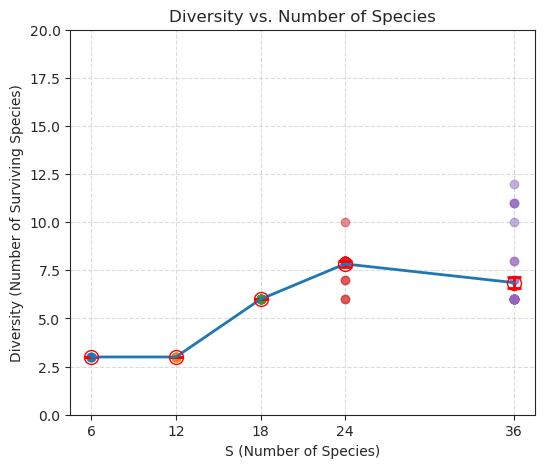

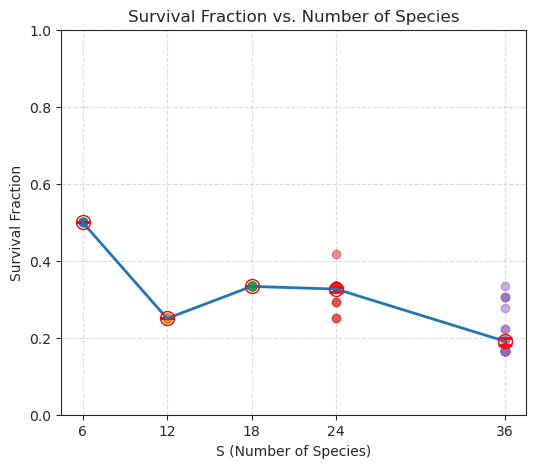


Summary Statistics:
S = 6:
 Mean Diversity: 3.00
 Standard Error of Diversity: 0.00
 Mean Survival Fraction: 0.50
 Standard Error of Survival Fraction: 0.00
 Number of Data Points: 6

S = 12:
 Mean Diversity: 3.00
 Standard Error of Diversity: 0.00
 Mean Survival Fraction: 0.25
 Standard Error of Survival Fraction: 0.00
 Number of Data Points: 12

S = 18:
 Mean Diversity: 6.00
 Standard Error of Diversity: 0.00
 Mean Survival Fraction: 0.33
 Standard Error of Survival Fraction: 0.00
 Number of Data Points: 18

S = 24:
 Mean Diversity: 7.83
 Standard Error of Diversity: 0.16
 Mean Survival Fraction: 0.33
 Standard Error of Survival Fraction: 0.01
 Number of Data Points: 24

S = 36:
 Mean Diversity: 6.86
 Standard Error of Diversity: 0.30
 Mean Survival Fraction: 0.19
 Standard Error of Survival Fraction: 0.01
 Number of Data Points: 36



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def calculate_diversity(species_vector, threshold=1e-6):
    return np.sum(species_vector > threshold)

# List of S values
S_values = [6, 12, 18, 24, 36]

# Dictionary to store diversities and survival fractions for each S
diversities = {S: [] for S in S_values}
survival_fractions = {S: [] for S in S_values}

# Load pickle files and calculate diversities and survival fractions
for S in S_values:
    session_path = f'Data/Results_standard/S{S}'
    pickle_file = os.path.join(session_path, 'result_and_description.pkl')
    if os.path.exists(pickle_file):
        data = load_pickle(pickle_file)
        result = data['result']
        for seed, sim_data in result.items():
            species_matrix = sim_data['species']
            # Calculate diversity and survival fraction for each condition (column)
            for condition in range(species_matrix.shape[1]):
                diversity = calculate_diversity(species_matrix[condition, :])
                diversities[S].append(diversity)
                survival_fractions[S].append(diversity / S)
    else:
        print(f"Warning: File not found for S={S}")

# Calculate mean and standard error for diversities and survival fractions
mean_diversities = []
stderr_diversities = []
mean_survival_fractions = []
stderr_survival_fractions = []

for S in S_values:
    if diversities[S]:
        mean_diversities.append(np.mean(diversities[S]))
        stderr_diversities.append(stats.sem(diversities[S]))
        mean_survival_fractions.append(np.mean(survival_fractions[S]))
        stderr_survival_fractions.append(stats.sem(survival_fractions[S]))
    else:
        mean_diversities.append(0)
        stderr_diversities.append(0)
        mean_survival_fractions.append(0)
        stderr_survival_fractions.append(0)

# Create scatter plot for diversity
plt.figure(figsize=(6, 5))
for S in S_values:
    plt.scatter([S] * len(diversities[S]), diversities[S], alpha=0.5)

# Plot mean and standard error for diversity
plt.errorbar(S_values, mean_diversities, yerr=stderr_diversities, fmt='o-', capsize=5, capthick=2, ecolor='red', markeredgecolor='red', markerfacecolor='none', markersize=10, linewidth=2)

plt.xlabel('S (Number of Species)')
plt.ylabel('Diversity (Number of Surviving Species)')
plt.title('Diversity vs. Number of Species')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(S_values)
plt.ylim(0, 20)
plt.savefig('Diversity_vs_S_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Create scatter plot for survival fraction
plt.figure(figsize=(6, 5))
for S in S_values:
    plt.scatter([S] * len(survival_fractions[S]), survival_fractions[S], alpha=0.5)

# Plot mean and standard error for survival fraction
plt.errorbar(S_values, mean_survival_fractions, yerr=stderr_survival_fractions, fmt='o-', capsize=5, capthick=2, ecolor='red', markeredgecolor='red', markerfacecolor='none', markersize=10, linewidth=2)

plt.xlabel('S (Number of Species)')
plt.ylabel('Survival Fraction')
plt.title('Survival Fraction vs. Number of Species')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(S_values)
plt.ylim(0, 1)
plt.savefig('Survival_Fraction_vs_S_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for S in S_values:
    print(f"S = {S}:")
    print(f" Mean Diversity: {np.mean(diversities[S]):.2f}")
    print(f" Standard Error of Diversity: {stats.sem(diversities[S]):.2f}")
    print(f" Mean Survival Fraction: {np.mean(survival_fractions[S]):.2f}")
    print(f" Standard Error of Survival Fraction: {stats.sem(survival_fractions[S]):.2f}")
    print(f" Number of Data Points: {len(diversities[S])}")
    print()

# 2. Can different states have same survivla speces set?

In [74]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def find_same_survival_different_values(species_matrix, threshold=1e-6, change_threshold=0.1):
    num_conditions, num_species = species_matrix.shape
    results = []

    for i in range(num_conditions):
        for j in range(i + 1, num_conditions):
            condition1 = species_matrix[i, :]
            condition2 = species_matrix[j, :]

            # Check if conditions are different enough
            relative_change = np.abs(np.sum(condition1)- np.sum(condition2))
            if np.max(relative_change) < 1e-2:
                continue

            # Check if the surviving species sets are the same
            surviving1 = set(np.where(condition1 > threshold)[0])
            surviving2 = set(np.where(condition2 > threshold)[0])

            if surviving1 == surviving2:
                results.append((i, j))

    return results

def plot_conditions(species_matrix, condition1, condition2, S, seed):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(range(len(species_matrix[condition1])), species_matrix[condition1])
    plt.title(f'Condition {condition1}')
    plt.xlabel('Species')
    plt.ylabel('Abundance')

    plt.subplot(1, 2, 2)
    plt.bar(range(len(species_matrix[condition2])), species_matrix[condition2])
    plt.title(f'Condition {condition2}')
    plt.xlabel('Species')
    plt.ylabel('Abundance')

    plt.suptitle(f'S={S}, Seed={seed}, Conditions {condition1} and {condition2}')
    plt.tight_layout()
    plt.savefig(f'S{S}_Seed{seed}_Conditions{condition1}_{condition2}.png')
    plt.close()

S_values = [6, 12, 18, 24, 36]
examples_found = 0

for S in S_values:
    if examples_found >= 5:
        break

    session_path = f'Data/Results_standard/S{S}'
    pickle_file = os.path.join(session_path, 'result_and_description.pkl')
    
    if os.path.exists(pickle_file):
        data = load_pickle(pickle_file)
        result = data['result']
        
        for seed, sim_data in result.items():
            if examples_found >= 5:
                break

            species_matrix = sim_data['species']
            matching_conditions = find_same_survival_different_values(species_matrix)
            
            for i, j in matching_conditions:
                print(f"Found example: S={S}, Seed={seed}, Conditions {i} and {j}")
                plot_conditions(species_matrix, i, j, S, seed)
                examples_found += 1
                
                if examples_found >= 5:
                    break
    else:
        print(f"Warning: File not found for S={S}")

print(f"Total examples found: {examples_found}")

Found example: S=18, Seed=49, Conditions 0 and 1
Found example: S=18, Seed=49, Conditions 0 and 2
Found example: S=18, Seed=49, Conditions 0 and 3
Found example: S=18, Seed=49, Conditions 0 and 4


Found example: S=18, Seed=49, Conditions 0 and 5
Total examples found: 5


In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def find_same_survival_different_values(species_matrix, threshold=1e-6, change_threshold=0.1):
    num_conditions, num_species = species_matrix.shape
    results = []

    for i in range(num_conditions):
        for j in range(i + 1, num_conditions):
            condition1 = species_matrix[i, :]
            condition2 = species_matrix[j, :]

            # Check if conditions are different enough
            relative_change = np.abs(condition1 - condition2) / np.maximum(condition1, condition2)
            if np.max(relative_change) < change_threshold:
                continue

            # Check if the surviving species sets are the same or differ by at most one species
            surviving1 = set(np.where(condition1 > threshold)[0])
            surviving2 = set(np.where(condition2 > threshold)[0])

            if len(surviving1.symmetric_difference(surviving2)) <= 1:
                results.append((i, j))

    return results

def plot_conditions(species_matrix, condition1, condition2, S, seed):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(range(len(species_matrix[condition1])), species_matrix[condition1])
    plt.title(f'Condition {condition1}')
    plt.xlabel('Species')
    plt.ylabel('Abundance')

    plt.subplot(1, 2, 2)
    plt.bar(range(len(species_matrix[condition2])), species_matrix[condition2])
    plt.title(f'Condition {condition2}')
    plt.xlabel('Species')
    plt.ylabel('Abundance')

    plt.suptitle(f'S={S}, Seed={seed}, Conditions {condition1} and {condition2}')
    plt.tight_layout()
    plt.savefig(f'S{S}_Seed{seed}_Conditions{condition1}_{condition2}.png')
    plt.close()

S_values = [6, 12, 18, 24, 36]
examples_found = 0

for S in S_values:
    if examples_found >= 5:
        break

    session_path = f'Data/Results_standard/S{S}'
    pickle_file = os.path.join(session_path, 'result_and_description.pkl')
    
    if os.path.exists(pickle_file):
        data = load_pickle(pickle_file)
        result = data['result']
        
        for seed, sim_data in result.items():
            if examples_found >= 5:
                break

            species_matrix = sim_data['species']
            matching_conditions = find_same_survival_different_values(species_matrix)
            
            for i, j in matching_conditions:
                print(f"Found example: S={S}, Seed={seed}, Conditions {i} and {j}")
                plot_conditions(species_matrix, i, j, S, seed)
                examples_found += 1
                
                if examples_found >= 5:
                    break
    else:
        print(f"Warning: File not found for S={S}")

print(f"Total examples found: {examples_found}")

/tmp/ipykernel_2639905/4249874556.py:20: RuntimeWarning: invalid value encountered in divide
  relative_change = np.abs(condition1 - condition2) / np.maximum(condition1, condition2)


Found example: S=6, Seed=49, Conditions 0 and 1
Found example: S=6, Seed=49, Conditions 0 and 2
Found example: S=6, Seed=49, Conditions 0 and 3
Found example: S=6, Seed=49, Conditions 0 and 4


Found example: S=6, Seed=49, Conditions 0 and 5
Total examples found: 5
